In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 情感分析(sentiment analysis)

下面快递评论文本数据的标签（`label`），数值$1$为正面意见(Positive)，数值$0$为负面意见(Negtive)

In [3]:
dat = pd.read_csv('datasets/waimai_10k.csv')
dat

,label,review
0,1,很快，好吃，味道足，量大
1,1,没有送水没有送水没有送水
2,1,非常快，态度好。
3,1,方便，快捷，味道可口，快递给力
4,1,菜味道很棒！送餐很及时！
...,...,...
11982,0,以前几乎天天吃，现在调料什么都不放，
11983,0,昨天订凉皮两份，什么调料都没有放，就放了点麻油，特别难吃，丢了一份，再也不想吃了
11984,0,"凉皮太辣,吃不下都"
11985,0,本来迟到了还自己点！！！


In [14]:
dat.label.value_counts()

label
0    7987
1    4000
Name: count, dtype: int64

In [4]:
import jieba
from sklearn.feature_extraction.text import CountVectorizer

d:\TGBAWork\.tgba_platform\venv\Lib\site-packages\jieba\_compat.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [5]:
text  = "量大，好吃，每次点的都够吃两次"

jieba.lcut(text)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\teach\AppData\Local\Temp\jieba.cache
Loading model cost 0.885 seconds.
Prefix dict has been built successfully.


['量', '大', '，', '好吃', '，', '每次', '点', '的', '都', '够吃', '两次']

In [6]:
text = "量大，好吃，每次点的都够吃两次"
segments = jieba.cut(text)

stopwords = set(["，", "。", "；", "！"])

def tokenizer_zh(text):
    return tuple(w for w in jieba.cut(text) if w not in stopwords )

vect = CountVectorizer(ngram_range=(1,2), tokenizer=tokenizer_zh, token_pattern=None)
vect.fit_transform([text])
vect.get_feature_names_out()

array(['两次', '够吃', '够吃 两次', '大', '大 好吃', '好吃', '好吃 每次', '每次', '每次 点', '点',
       '点 的', '的', '的 都', '都', '都 够吃', '量', '量 大'], dtype=object)

In [9]:
import jieba

reviews = [" ".join(jieba.cut(txt)) for txt in dat.review]

In [10]:
reviews[0]

'很快 ， 好吃 ， 味道 足 ， 量 大'

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reviews, dat.label, stratify= dat.label, random_state=42)

In [13]:

def tokenizer_zh(text):
    return tuple(w for w in jieba.cut(text) if w not in stopwords )


cnt_vect = CountVectorizer(min_df=10, ngram_range=(1,1), tokenizer=tokenizer_zh, token_pattern=None)
cnt_vect.fit(X_train)

X_train_vect = cnt_vect.transform(X_train)
X_test_vect = cnt_vect.transform(X_test)

print(repr(X_train_vect))
print(repr(X_test_vect))


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

cnt_model = LogisticRegression(solver='lbfgs', max_iter=1000)
cnt_model.fit(X_train_vect, y_train)

print("Training accuracy: ", accuracy_score(cnt_model.predict(X_train_vect), y_train))
print("Testing accuracy: ", accuracy_score(cnt_model.predict(X_test_vect), y_test))

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 106999 stored elements and shape (8990, 1258)>
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 36172 stored elements and shape (2997, 1258)>
Training accuracy:  0.9208008898776419
Testing accuracy:  0.8862195528862196


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(min_df=10, ngram_range=(1,2), tokenizer=tokenizer_zh, token_pattern=None)

tfidf_vect.fit(X_train)

X_train_vect = tfidf_vect.transform(X_train)
X_test_vect = tfidf_vect.transform(X_test)

In [15]:
from sklearn.linear_model import LogisticRegression

tfidf_model = LogisticRegression(solver='lbfgs', max_iter=1000)
tfidf_model.fit(X_train_vect, y_train)

from sklearn.metrics import accuracy_score

print("Training accuracy: ", accuracy_score(tfidf_model.predict(X_train_vect), y_train))
print("Testing accuracy: ", accuracy_score(tfidf_model.predict(X_test_vect), y_test))

Training accuracy:  0.9208008898776419
Testing accuracy:  0.8862195528862196


In [16]:
def plot_coefficients(coefficients, labels=None, ax=None):
    """
    以柱状图的方式显示系数
    """
    if ax is None: ax = plt.gca()
    
    ax.axhline(y=0, c="grey", lw=1)

    pos_val = coefficients[coefficients>=0]
    pos_idx = np.where(coefficients>=0)[0]
    neg_val = coefficients[coefficients<0]
    neg_idx = np.where(coefficients<0)[0]

    ax.bar(pos_idx, pos_val)
    ax.bar(neg_idx, neg_val)
    ax.set_ylabel("coefficients")

    ax.axes.set_xticks(range(len(coefficients)))
    if labels is not None:
        ax.axes.set_xticklabels(labels, horizontalalignment='right', rotation=45)
        
    ax.margins(y=0.15)
    for p in ax.patches:
        ax.annotate(f"{ p.get_height() :.2f}", 
                    xy=(p.get_x() + p.get_width() / 2., p.get_height()), 
                    xytext = (0, 8 if p.get_height() >= 0 else -8),
                    ha = 'center', va = 'center', textcoords = 'offset points')

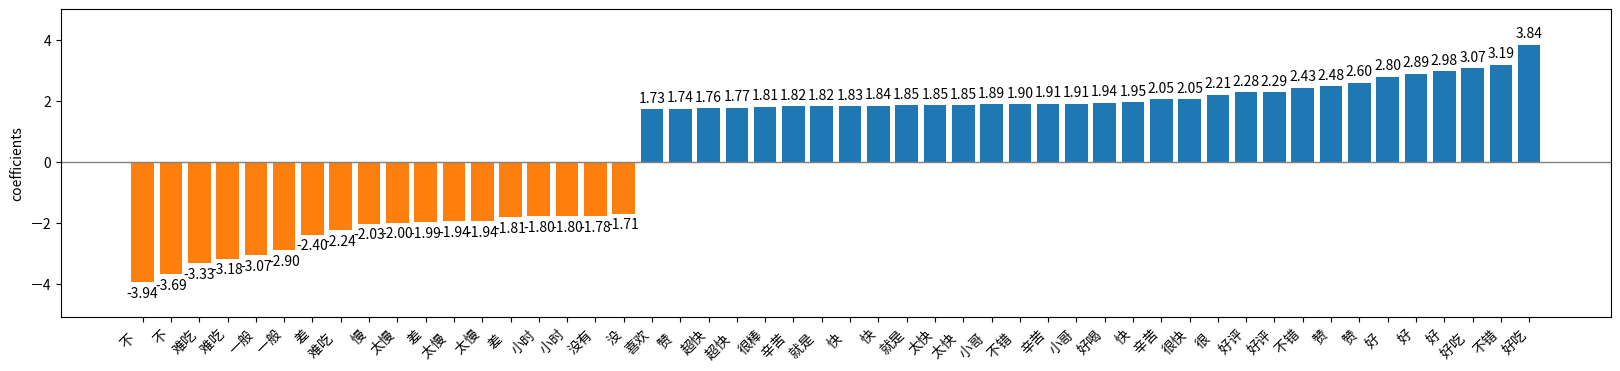

In [17]:
top_idxs = np.abs(tfidf_model.coef_.ravel()).argsort()[-50:] # 找出前50个模型系数绝对值最大的数据下标

top_ceofs = tfidf_model.coef_.ravel()[top_idxs]
top_names = tfidf_vect.get_feature_names_out()[top_idxs]

label_idxs = top_ceofs.argsort()

plt.figure(figsize=(20, 4))
plot_coefficients(top_ceofs[label_idxs], labels=top_names[label_idxs])

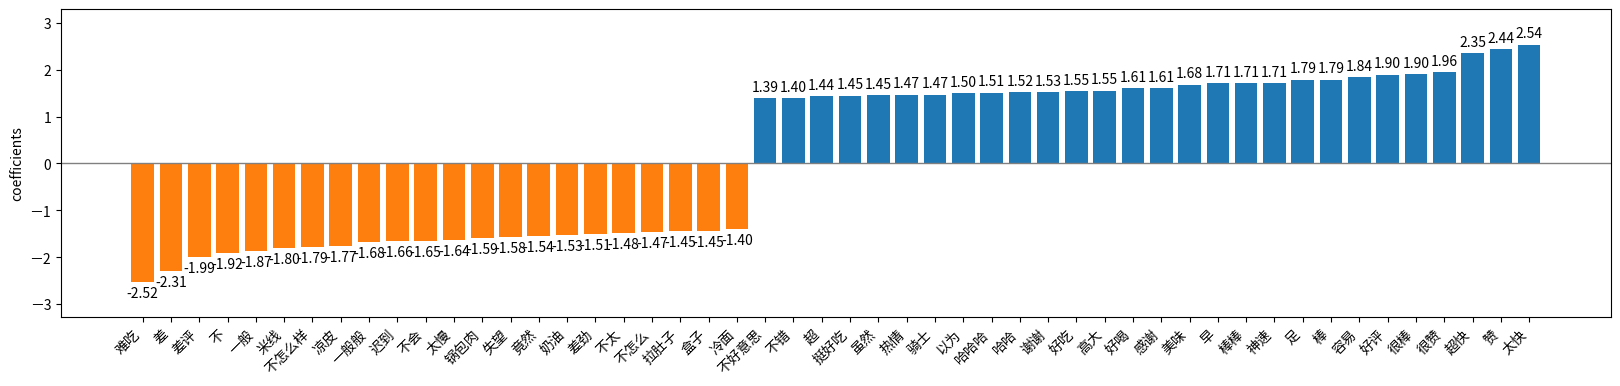

In [18]:
top_idxs = np.abs(cnt_model.coef_.ravel()).argsort()[-50:] # 找出前50个模型系数绝对值最大的数据下标

top_ceofs = cnt_model.coef_.ravel()[top_idxs]
top_names = cnt_vect.get_feature_names_out()[top_idxs]


label_idxs = top_ceofs.argsort()

plt.figure(figsize=(20, 4))
plot_coefficients(top_ceofs[label_idxs], labels=top_names[label_idxs])